# start

In [1]:
# load data file from Roger github
# !wget -nc https://github.com/rogersoh/datascience/raw/refs/heads/main/data/kc_house_data.csv

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold, cross_val_score

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_percentage_error

from typing_extensions import Final
from sklearn import set_config
import time

set_config(transform_output="pandas")

# Load Data

In [8]:
kc = pd.read_csv("kc_house_data.csv")
print("kc shape", kc.shape)
kc.head()

kc shape (21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [10]:
print("Duplicate record: ",kc.duplicated().sum() )# Check for duplicate
print("Count of zipcode")
print(kc["zipcode"].value_counts().sort_values(ascending=False))

print("\nMissing value = ", kc.isna().sum().sum())


Duplicate record:  0
Count of zipcode
zipcode
98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: count, Length: 70, dtype: int64

Missing value =  0


# Function Definition

In [13]:
# Initial
kf = KFold(n_splits=5)
scoring_metric: Final = "r2"
RandomStateNumber: Final = 13

In [15]:
# Cross validation
def crossVal(model, X, y, kf, scoring_metric, title):
    scores = cross_val_score(model, X, y, cv=kf, scoring=scoring_metric, n_jobs=-1)
    mean = scores.mean()
    std = scores.std()
    print(f"Cross validation {scoring_metric} scores: {scores}")
    print(f"Mean {scoring_metric}: {scores.mean():.4f}")
    print(f"Standard deviation {scoring_metric}: {scores.std():.4f}")
    score_dict = {
        "model": model.__class__.__name__,  
        "title": title,
        "r2 mean": mean,
        "r2 standard deviation": std
    }
    return score_dict

In [17]:
# Feature Engineering
def feature_engineer(data):
  df = data.copy()
  df["year"] = df["date"].str[:4].astype(int)
  df["house_age"] = df["year"] - df["yr_built"]
  df["renovated"] = df["yr_renovated"].astype("bool")
  return df

In [19]:
# Evaluate model
def evaluate_model(model, X_test, y_test, y_train, title = None):

  y_pred = model.predict(X_test)
  
  logPrice = True if np.max(y_test) <= 100  else False

  if logPrice:
    baseline = root_mean_squared_error(np.exp(y_test), np.full(len(y_test), np.exp(y_train).mean()))
    rmse_actual = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
    mspe_actual = mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred))

  else:
    baseline = root_mean_squared_error(y_test, np.full(len(y_test), y_train.mean()))
    rmse_actual = root_mean_squared_error(y_test, y_pred)
    mspe_actual = mean_absolute_percentage_error(y_test, y_pred)

  summary = {}
  print(f"{title}\n")
  if hasattr(model, 'best_estimator_'):
    print("Best Model:", model.best_estimator_)
    print("Best Parameters:", model.best_params_)
    print(f"Best Score : {model.best_score_}\n")
  else:
    print("Model:", model)
    print("\nEvaluating the provided model on test data")

  print("\nEvaluation on test data")
  
  r2 = r2_score(y_test, y_pred)
  # RMSE_orginal_scale = root_mean_squared_error(np.exp(y_test), np.exp(y_pred))
  residual = y_test - y_pred
  rmse = root_mean_squared_error(y_test, y_pred)

  print("R2 score: ", r2)
  print("RMSE: ", rmse)
  # print(f"RMSE on orginal scale: {RMSE_orginal_scale: ,.0f}")
  print(f"RMSE on orginal scale: {rmse_actual: ,.0f}")
  print(f"MSPE on orginal scale: {mspe_actual: ,.2%}")
  print(f"Baseline RMSE on orginal scale: {baseline: ,.0f}")

  fig = plt.figure(figsize=(8,5), layout = "constrained")
  ax1 = fig.add_subplot(121)
  ax1.scatter(y_test, residual)
  plt.axhline(y=0, color='r', linestyle='--')
  plt.xlabel('Actual')
  plt.ylabel('Residuals')
  plt.title('Actual vs Residual', fontsize=10)

  ax2 = fig.add_subplot(122)
  plt.scatter(y_test, y_pred)
  plt.plot(y_test, y_test, color='r', linestyle='--')
  plt.xlabel('Actual')
  plt.ylabel('Predicted')
  plt.title('Actual vs. Predicted', fontsize=10)
  plt.show()

  summary["Model"] = title
  summary["r2"] = r2
  summary["RMSE"] = rmse
  summary["RMSE_orginal_scale"] = rmse_actual
  summary["MSPE_orginal_scale"] = mspe_actual
  summary["baseline_orginal_scale_RMSE"] = baseline

  return summary


# EDA

In [22]:
kc.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.400881e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.671272e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


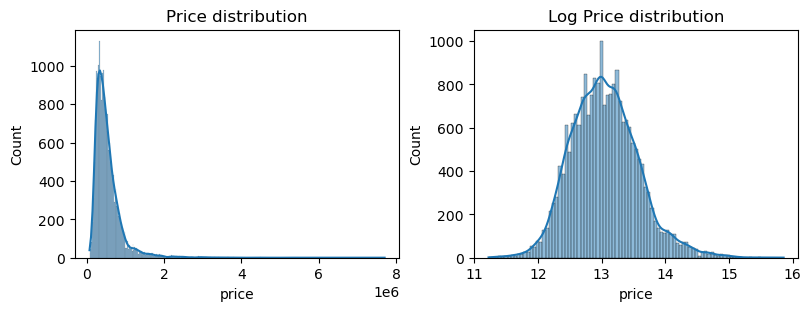

In [24]:
fig = plt.figure(figsize=(8,3), layout = "constrained")
ax1 = fig.add_subplot(121)
sns.histplot(kc["price"], kde=True, ax= ax1)
ax1.set_title("Price distribution")
ax2 = fig.add_subplot(122)
sns.histplot(np.log(kc["price"]), kde=True, ax= ax2)
ax2.set_title("Log Price distribution")
plt.show()

kc["log_price"] = np.log(kc["price"])
# The price distribution are right skew, log the price to normalise it.

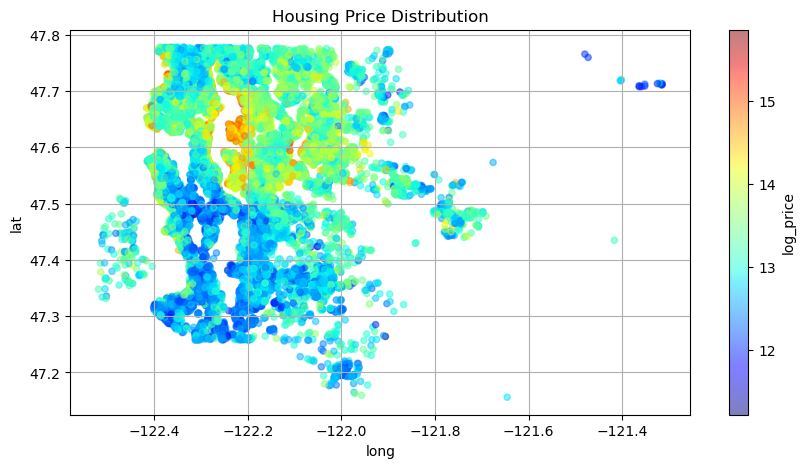

In [26]:
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)
kc.plot(kind = "scatter", x = "long", y = "lat",
        grid = True, c = "log_price", cmap="jet",
        colorbar = True, alpha= 0.5 ,ax= ax)
ax.set_title("Housing Price Distribution")
plt.show()

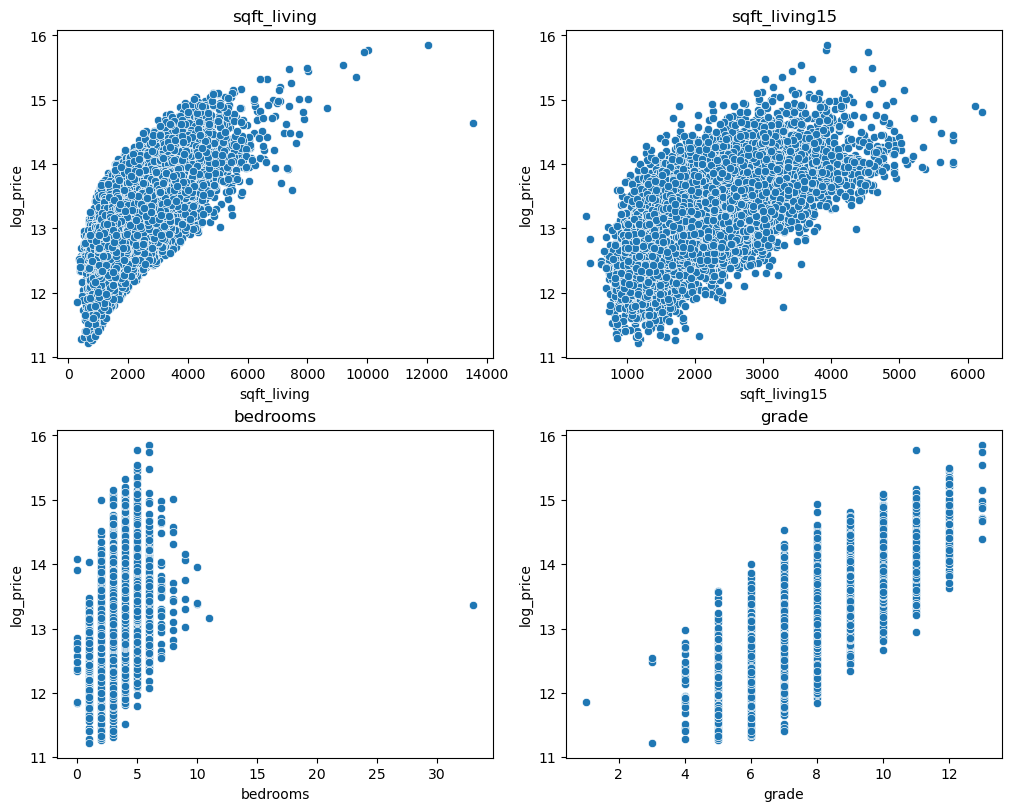

In [28]:
fig = plt.figure(figsize=(10,8), layout="constrained")
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.scatterplot(kc, x = "sqft_living", y = "log_price", ax=ax1)
ax1.set_title("sqft_living")
sns.scatterplot(kc, x = "sqft_living15", y = "log_price", ax=ax2)
ax2.set_title("sqft_living15")
sns.scatterplot(kc, x = "bedrooms", y = "log_price", ax=ax3)
ax3.set_title("bedrooms")
sns.scatterplot(kc, x = "grade", y = "log_price", ax=ax4)
ax4.set_title("grade")
plt.show()

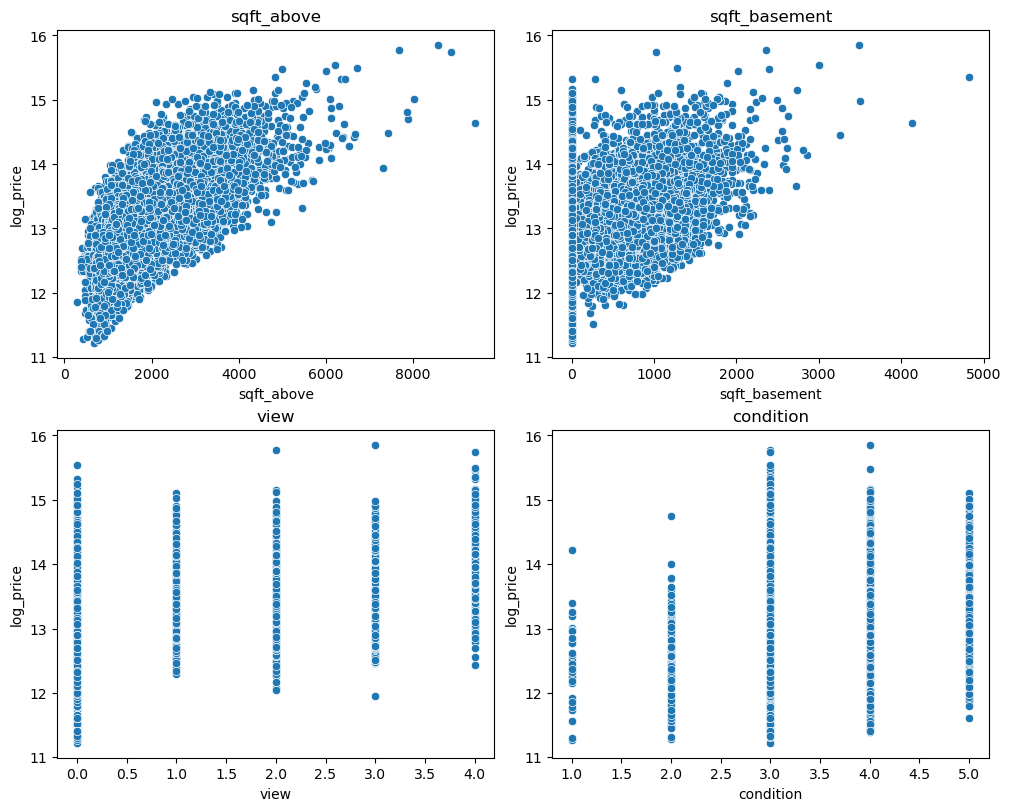

In [30]:
fig = plt.figure(figsize=(10,8), layout="constrained")
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
sns.scatterplot(kc, x = "sqft_above", y = "log_price", ax=ax1)
ax1.set_title("sqft_above")
sns.scatterplot(kc, x = "sqft_basement", y = "log_price", ax=ax2)
ax2.set_title("sqft_basement")
sns.scatterplot(kc, x = "view", y = "log_price", ax=ax3)
ax3.set_title("view")
sns.scatterplot(kc, x = "condition", y = "log_price", ax=ax4)
ax4.set_title("condition")
plt.show()

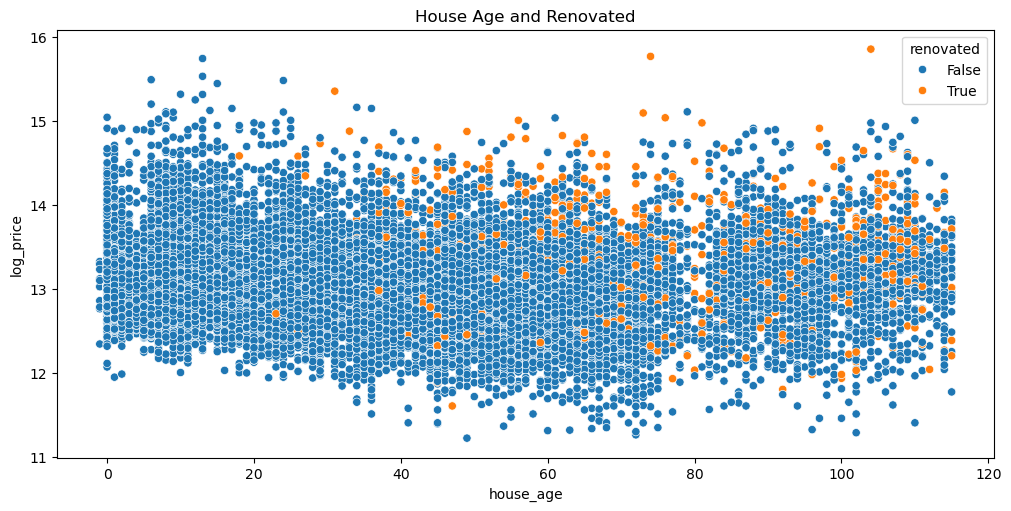

In [32]:
kc_feature_engineered = feature_engineer(kc)

fig = plt.figure(figsize=(10,5), layout = "constrained")
sns.scatterplot(kc_feature_engineered, x = "house_age", y = "log_price", hue = "renovated")
plt.title("House Age and Renovated")
plt.show()

# Data cleaning

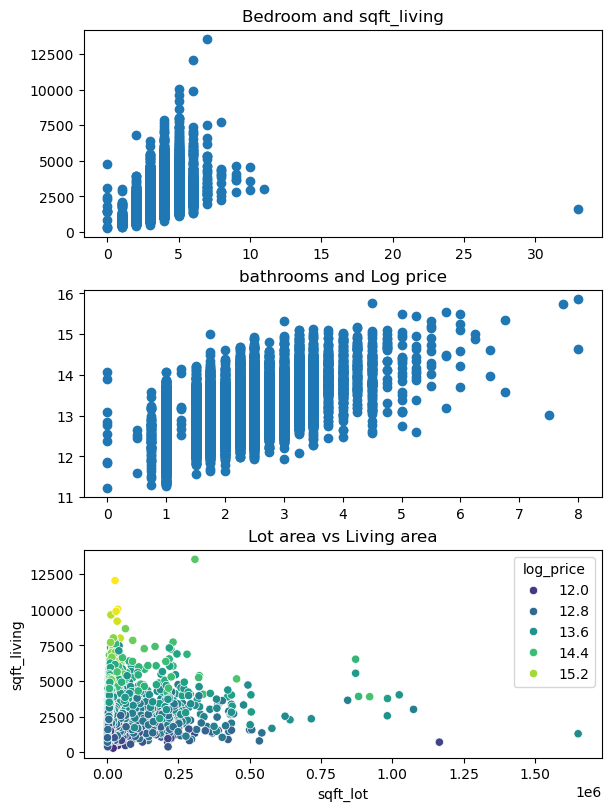

In [35]:
fig = plt.figure(figsize=(6,8), layout = "constrained")
ax1 = fig.add_subplot(311)
ax1.scatter(x= kc["bedrooms"], y = kc["sqft_living"])
# sns.boxplot(kc["bedrooms"], ax=ax1, )
ax1.set_title("Bedroom and sqft_living")
ax2 = fig.add_subplot(312)
ax2.scatter(kc["bathrooms"], kc["log_price"])
ax2.set_title("bathrooms and Log price")
ax3 = fig.add_subplot(313)
sns.scatterplot(kc, x = "sqft_lot", y = "sqft_living", hue = "log_price",
                palette = "viridis",
                ax= ax3)
ax3.set_title("Lot area vs Living area")

plt.show()

In [37]:
# Outlier
print("\nRecords that have outlier in bedroom:")
print(f'{kc[kc["bedrooms"]>15][:][["bedrooms", "sqft_living"]]} ')
print("\nRecords that have outlier in bathroom:")
print(kc[kc["bathrooms"]>=7][:][["bathrooms", "bedrooms", "sqft_living"]])
print("\nRecords that have outlier in sqft_living:")
print(kc[kc["sqft_living"]>12000][:][["bathrooms", "bedrooms", "sqft_living"]])
print("\nRecords that have outlier in sqft_lot:")
print(kc[kc["sqft_lot"]>0.75e6][:][["bathrooms", "bedrooms", "sqft_living", "sqft_lot"]])


Records that have outlier in bedroom:
       bedrooms  sqft_living
15870        33         1620 

Records that have outlier in bathroom:
       bathrooms  bedrooms  sqft_living
7252        8.00         6        12050
8546        7.50         9         4050
9254        7.75         6         9890
12777       8.00         7        13540

Records that have outlier in sqft_living:
       bathrooms  bedrooms  sqft_living
7252         8.0         6        12050
12777        8.0         7        13540

Records that have outlier in sqft_lot:
       bathrooms  bedrooms  sqft_living  sqft_lot
1719        1.00         4         1300   1651359
3949        3.25         4         3770    982998
4441        3.00         2         2560    982278
4540        2.00         3         3650    843309
6691        2.50         2         3900    920423
7077        3.25         4         3920    881654
7647        3.25         5         3010   1074218
7769        3.50         4         4030   1024068
9714     

In [39]:
# drop the outlier records
kc_cleaned = kc.copy()
kc_cleaned = kc_cleaned[kc_cleaned["bedrooms"]<15]
kc_cleaned = kc_cleaned[kc_cleaned["bathrooms"]<7]
kc_cleaned = kc_cleaned[kc_cleaned["sqft_living"]<12000]
kc_cleaned = kc_cleaned[kc_cleaned["sqft_lot"]<0.75e6]
kc_cleaned.shape

(21597, 22)

# Pipeline

In [42]:
minmaxCols = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors','view',
              'condition', 'grade', 'sqft_above','sqft_basement', 'sqft_living15',
              'sqft_lot15', "house_age"]

scaleCols = ["long", "lat"]

feature_transform = FunctionTransformer(feature_engineer)

column_drop = ["id", "date", "yr_built", "yr_renovated", "year", "zipcode"]


columnTransform = ColumnTransformer(
    transformers=[
        ("minmax", MinMaxScaler(), minmaxCols),
        ("scale", StandardScaler(), scaleCols),
    ],
    remainder="passthrough",
    verbose_feature_names_out= False
)

dropColumn = ColumnTransformer(
    transformers=[
        ("drop", "drop", column_drop),
    ],
    remainder="passthrough",
    verbose_feature_names_out= False
)

preprocessing = Pipeline([
    ("feature_engineer", feature_transform),
    ("dropColumn", dropColumn),
    ("columnTransform", columnTransform)
])

# Dropping insignificant features

# removed = ["sqft_lot", "condition", "sqft_lot15", "sqft_above", "sqft_basement", 
#            "house_age", "waterfront"]
removed = ["sqft_lot", "condition", "sqft_basement", "sqft_above", "sqft_lot15", 
           "house_age", "waterfront", "renovated"] # List of features to be removed, from correlation analysis

removedDrop = ColumnTransformer(
    transformers=[
        ("removed", "drop", removed),
    ],
    remainder="passthrough",
    verbose_feature_names_out= False
)

featureRM_preprocessing = Pipeline([
    ("preprocessing", preprocessing),
    ("removedDrop", removedDrop)
])

# Create pipeline
pipe = Pipeline([
    ('classifier', Lasso(random_state= 13))  # Placeholder model
])

bestSelectPipe = Pipeline([
    ('feature_engineer', feature_transform),
    ('dropColumn', dropColumn),
    ('columnTransform', columnTransform),
    ('removedDrop', removedDrop),
    ('classifier', pipe)
])

# Split and encord data

In [45]:
X = kc_cleaned.drop(columns = ["price", "log_price"], axis = 1)
y = kc_cleaned["log_price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state= 13)

# scaling
X_train_scaled = preprocessing.fit_transform(X_train)
X_test_scaled = preprocessing.transform(X_test)

# Modeling

## Machine Learning Training, Hypertuning, validation, evalation

### Features selection

In [21]:
# Table scores for feature selection
features_scores = []


In [22]:
# Random Forest Regressor full features 
forest = RandomForestRegressor(random_state=RandomStateNumber)
forest.fit(X_train_scaled, y_train)

crossValScore = crossVal(forest, X_train_scaled, y_train, kf, scoring_metric, "Full features")

features_scores.append(crossValScore)


Cross validation r2 scores: [0.87901636 0.88550906 0.87657004 0.88259126 0.88416426]
Mean r2: 0.8816
Standard deviation r2: 0.0033


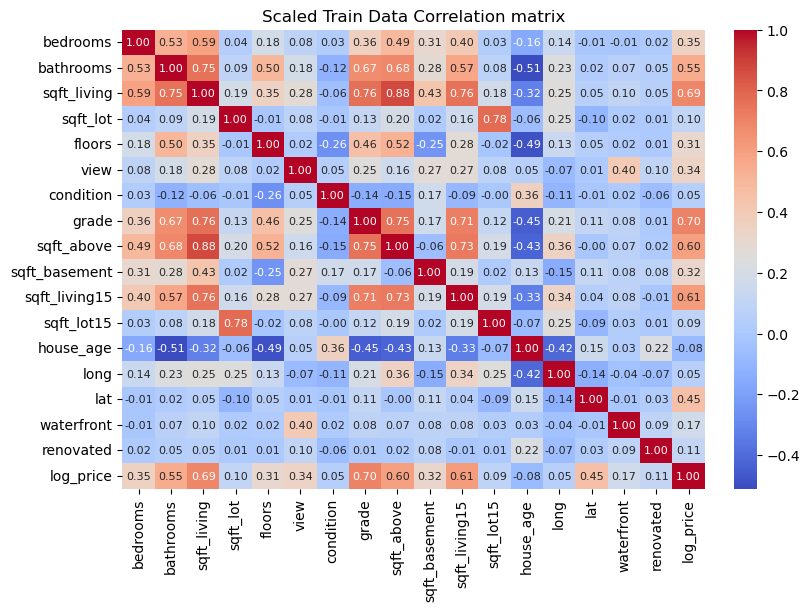

In [23]:
# from correlation matrix
Xy_train_scaled = pd.concat([X_train_scaled, y_train], axis = 1)

corr_matrix = Xy_train_scaled.corr()

fig = plt.figure(figsize=(8,6), layout = "constrained")
sns.heatmap(Xy_train_scaled.corr(), annot=True, fmt = ".2f", cmap="coolwarm", annot_kws={"size":8})
plt.title("Scaled Train Data Correlation matrix")
plt.show()

In [24]:
# removed1
removed = ["sqft_lot", "condition", "sqft_basement", "sqft_above", "sqft_lot15", 
           "house_age", "waterfront", "renovated"]
X_train_removed1 = X_train_scaled.drop(columns=removed, axis=1)
X_test_removed1 = X_test_scaled.drop(columns=removed, axis=1)


In [25]:
X_test_removed1.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'floors', 'view', 'grade',
       'sqft_living15', 'long', 'lat'],
      dtype='object')

In [26]:
# Random Forest Regressor removed1 
forest = RandomForestRegressor(random_state=RandomStateNumber)
forest.fit(X_train_removed1 , y_train)

crossValScore = crossVal(forest, X_train_removed1, y_train, kf, scoring_metric, "Removed1, correlation matrix")

features_scores.append(crossValScore)

Cross validation r2 scores: [0.86962335 0.87856958 0.8715946  0.87559603 0.87542843]
Mean r2: 0.8742
Standard deviation r2: 0.0032


In [27]:
def randomForestFeatureImportance(forest):
  important = forest.feature_importances_
  columns = forest.feature_names_in_
  importantFeatures = pd.Series(important, columns).sort_values(ascending=False)
  fig = plt.figure(figsize=(5,3), layout = "constrained")
  importantFeatures.sort_values(ascending = True).plot.barh(color="blue")
  plt.title("Feature Importance - Removed1", fontsize=10)
  plt.show()

Variance of each scaled feature:
long             1.000058
lat              1.000058
house_age        0.064697
floors           0.046570
renovated        0.040841
view             0.036192
condition        0.026229
sqft_living15    0.014277
grade            0.013701
bathrooms        0.012838
sqft_above       0.011553
sqft_living      0.009613
sqft_basement    0.008318
bedrooms         0.008216
waterfront       0.007297
sqft_lot         0.002188
sqft_lot15       0.002045
dtype: float64


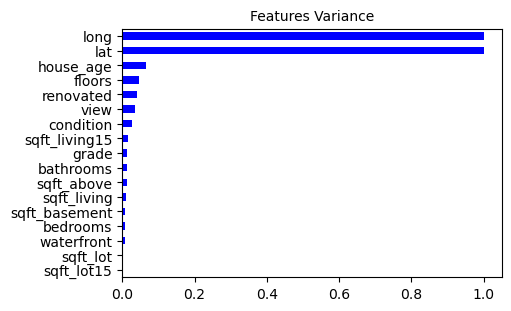

In [28]:
# Variance of each scaled feature
print("Variance of each scaled feature:")
var_train = pd.Series(X_train_scaled.var(axis=0), X_train_scaled.columns).sort_values(ascending=False)
print(var_train)
fig = plt.figure(figsize=(5,3), layout = "constrained")

var_train.sort_values(ascending = True).plot.barh(color="blue")
plt.title("Features Variance", fontsize=10)
plt.show()

# removed2
removed2 = var_train[var_train<0.01].index.tolist()
X_train_removed2 = X_train_scaled.drop(columns=removed, axis=1)
X_test_removed2 = X_test_scaled.drop(columns=removed, axis=1)

In [29]:
# Random Forest Regressor removed2
forest = RandomForestRegressor(random_state=RandomStateNumber)
forest.fit(X_train_removed2 , y_train)

crossValScore = crossVal(forest, X_train_removed2, y_train, kf, scoring_metric, "Removed2, Variance < 0.01")

features_scores.append(crossValScore)

Cross validation r2 scores: [0.86962335 0.87856958 0.8715946  0.87559603 0.87542843]
Mean r2: 0.8742
Standard deviation r2: 0.0032


In [30]:
# Using the Random Forest Regressor to determine feature importance
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

r2scorelist = []
for k in range(1, X_train_scaled.shape[1] + 1):
    selector = SelectKBest(score_func=mutual_info_regression, k=k)
    X_train_kbest = selector.fit_transform(X_train_scaled, y_train)
    X_test_kbest = selector.transform(X_test_scaled)

    forest.fit(X_train_kbest, y_train)
    cross_val_scores = cross_val_score(forest, X_train_kbest, y_train, cv=kf, scoring=scoring_metric)
    train_cv_r2 =  cross_val_scores.mean()
    r2scorelist.append((k, train_cv_r2))



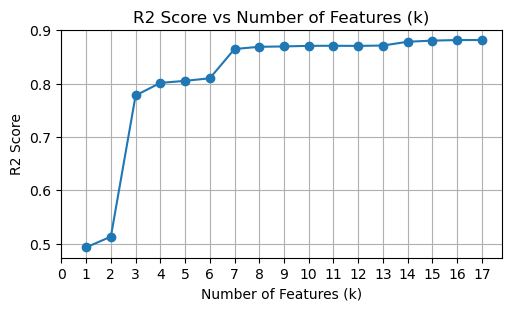

In [31]:
r2score = pd.Series(dict(r2scorelist), name="r2_score")
r2score.index.name = "k"
fig = plt.figure(figsize=(5,3), layout = "constrained")
r2score.plot(marker='o')
plt.title("R2 Score vs Number of Features (k)")
plt.xlabel("Number of Features (k)")
plt.ylabel("R2 Score")
plt.xticks(np.arange(0, X_train_scaled.shape[1] + 1, 1))
plt.grid()
plt.show()


In [32]:
# Select the top 7 features based on mutual information regression
selector = SelectKBest(score_func=mutual_info_regression, k=7)
X_train_kbest = selector.fit_transform(X_train_scaled, y_train)
X_test_kbest = selector.transform(X_test_scaled)
print("column: ", X_train_kbest.columns.tolist())


column:  ['bathrooms', 'sqft_living', 'grade', 'sqft_above', 'sqft_living15', 'long', 'lat']


In [33]:
# Random Forest Regressor removed3
forest = RandomForestRegressor(random_state=RandomStateNumber)
forest.fit(X_train_kbest , y_train)

crossValScore = crossVal(forest, X_train_kbest, y_train, kf, scoring_metric, "Removed3, keep using kbest")

features_scores.append(crossValScore)

Cross validation r2 scores: [0.85838212 0.86671275 0.86091323 0.86890537 0.86874949]
Mean r2: 0.8647
Standard deviation r2: 0.0043


In [34]:
score_df = pd.DataFrame(features_scores).sort_values(by="r2 mean", ascending = False)
score_df

,model,title,r2 mean,r2 standard deviation
0,RandomForestRegressor,Full features,0.881570,0.003311
1,RandomForestRegressor,"Removed1, correlation matrix",0.874162,0.003171
2,RandomForestRegressor,"Removed2, Variance < 0.01",0.874162,0.003171
3,RandomForestRegressor,"Removed3, keep using kbest",0.864733,0.004298


In [51]:
# feature selection from correlation analysis, assigned to removed in the featureRM_preprocessing pipeline
# it has the lowest r2 standard deviation in the cross validation
# removed:["sqft_lot", "condition", "sqft_basement", "sqft_above", "sqft_lot15", 
#            "house_age", "waterfront", "renovated"]
X_train_selected = featureRM_preprocessing.fit_transform(X_train)
X_test_selected = featureRM_preprocessing.transform(X_test)
X_train_selected.head()

,bedrooms,bathrooms,sqft_living,floors,view,grade,sqft_living15,long,lat
11569,0.2,0.333333,0.092772,0.4,0.0,0.5,0.145509,-0.619157,0.431685
19517,0.2,0.148148,0.122977,0.0,0.0,0.4,0.163019,-0.590670,0.390512
8997,0.3,0.370370,0.217907,0.4,0.0,0.5,0.254071,1.182675,-1.593016
21353,0.3,0.370370,0.230852,0.4,0.0,0.5,0.371389,0.840825,1.005940
17454,0.3,0.333333,0.135922,0.0,0.0,0.4,0.213798,-0.127748,1.213972


### Hyperparameter tuning

In [54]:
# initialise summaries
summaries = []

In [56]:
# random forest with features selection by correlation matrix
param_grid_forest = [
    {
        'classifier': [RandomForestRegressor(random_state= RandomStateNumber)],
        'classifier__n_estimators': [100, 200, 300],
        'classifier__max_depth': [5, 10, 15, None],
        'classifier__max_features': [0.5, 0.75, 'sqrt', 'log2'],
        'classifier__min_samples_leaf': [1, 5, 10]
    }
]

grid_forest = GridSearchCV(pipe,
                          param_grid = param_grid_forest,
                          scoring= scoring_metric,
                          n_jobs = -1,
                          cv = kf,
                          verbose=1
                          )
start_time = time.time()
grid_forest.fit(X_train_selected, y_train)
print("Time taken sec", time.time() - start_time)

Fitting 5 folds for each of 144 candidates, totalling 720 fits


/Users/sohengkhiong/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken sec 238.6952519416809


Random Forest Regressor

Best Model: Pipeline(steps=[('classifier',
                 RandomForestRegressor(max_depth=15, max_features=0.75,
                                       n_estimators=300, random_state=13))])
Best Parameters: {'classifier': RandomForestRegressor(random_state=13), 'classifier__max_depth': 15, 'classifier__max_features': 0.75, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 300}
Best Score : 0.878228018049616


Evaluation on test data
R2 score:  0.8862573693344251
RMSE:  0.17707959271529775
RMSE on orginal scale:  146,259
MSPE on orginal scale:  12.85%
Baseline RMSE on orginal scale:  381,572


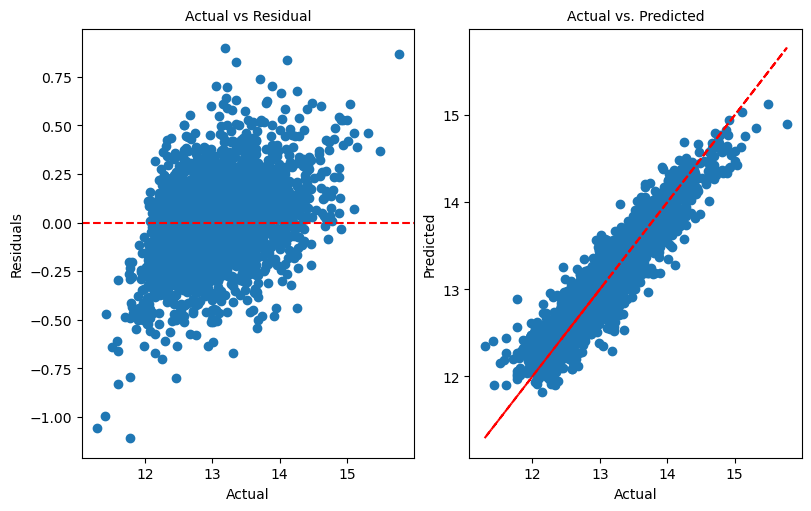

,Model,r2,RMSE,RMSE_orginal_scale,MSPE_orginal_scale,baseline_orginal_scale_RMSE
0,Random Forest Regressor,0.886257,0.17708,146259.187589,0.128452,381572.388539


In [57]:
summary = evaluate_model(grid_forest, X_test_selected, y_test, y_train, title = "Random Forest Regressor")
summaries.append(summary)
pd.DataFrame(summaries).sort_values(by="r2", ascending=False)

In [73]:
# grid_forest_bselect = GridSearchCV(bestSelectPipe,
#                           param_grid = param_grid_forest,
#                           scoring= scoring_metric,
#                           n_jobs = -1,
#                           cv = kf,
#                           verbose=1
#                           )
# start_time = time.time()
# grid_forest_bselect.fit(X_train, y_train)
# print("Time taken sec", time.time() - start_time)

# summary = evaluate_model(grid_forest_bselect, X_test, y_test, y_train, title = "Random Forest Regressor Best select pipeline")
# summaries.append(summary)
# pd.DataFrame(summaries).sort_values(by="r2", ascending=False)

In [74]:
# Gradient Boosting Regressor
param_grid_gb = [
  {
    'classifier': [GradientBoostingRegressor(random_state= RandomStateNumber)],
    'classifier__loss':['squared_error', 'absolute_error', 'huber', 'quantile'],
    'classifier__learning_rate': np.linspace(0.001, 0.2, 20),
    'classifier__max_depth':[3, 4, 5, 8, 10],
    'classifier__n_estimators': [100, 200, 400, 500],
    'classifier__max_features':["sqrt", "log2", 0.7, None]
  }]

grid_gb = RandomizedSearchCV(pipe,
                          param_distributions = param_grid_gb,
                          scoring= scoring_metric,
                          n_iter=50,
                          n_jobs = -1,
                          cv = kf,
                          random_state= RandomStateNumber,
                          verbose=1)

start_time = time.time()
grid_gb.fit(X_train_selected, y_train)
print(f"Training time in seconds {time.time()- start_time :.0f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training time in seconds 177


Gradient Boosting Regressor

Best Model: Pipeline(steps=[('classifier',
                 GradientBoostingRegressor(learning_rate=0.03242105263157895,
                                           max_depth=8, max_features='log2',
                                           n_estimators=200,
                                           random_state=13))])
Best Parameters: {'classifier__n_estimators': 200, 'classifier__max_features': 'log2', 'classifier__max_depth': 8, 'classifier__loss': 'squared_error', 'classifier__learning_rate': 0.03242105263157895, 'classifier': GradientBoostingRegressor(random_state=13)}
Best Score : 0.8849065018652146


Evaluation on test data
R2 score:  0.890415706926371
RMSE:  0.17381251166484749
RMSE on orginal scale:  137,353
MSPE on orginal scale:  12.72%
Baseline RMSE on orginal scale:  381,572


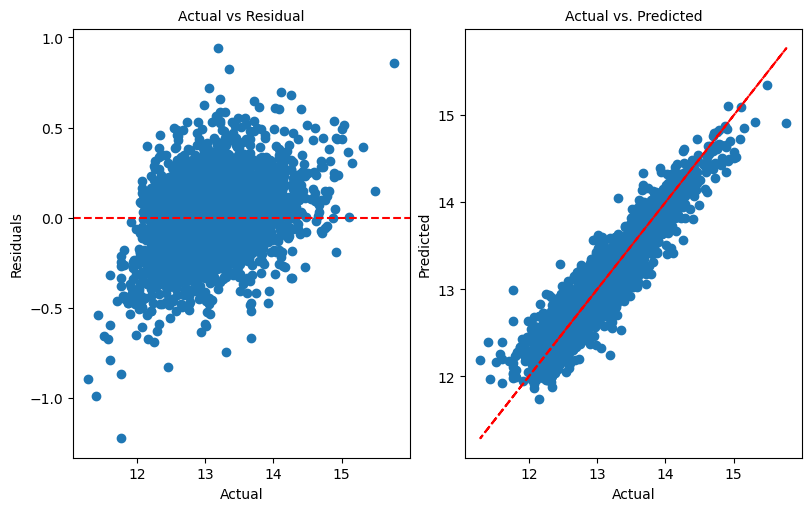

,Model,r2,RMSE,RMSE_orginal_scale,MSPE_orginal_scale,baseline_orginal_scale_RMSE
1,Gradient Boosting Regressor,0.890416,0.173813,137352.779287,0.127204,381572.388539
0,Random Forest Regressor,0.886257,0.177080,146259.187589,0.128452,381572.388539


In [75]:
summary = evaluate_model(grid_gb, X_test_selected, y_test, y_train, title = "Gradient Boosting Regressor")
summaries.append(summary)
pd.DataFrame(summaries).sort_values(by="r2", ascending=False)

In [76]:
# Lasso Regression
param_grid_lasso = [
    {
        "classifier": [Lasso(random_state = RandomStateNumber)],
        "classifier__alpha": [0.0001, 0.001, 0.01, 1, 10],
        "classifier__selection":["cyclic", "random"]
    }]

grid_lasso = GridSearchCV(pipe,
                          param_grid = param_grid_lasso,
                          scoring= scoring_metric,
                          n_jobs = -1,
                          cv = kf,
                          verbose=1)
grid_lasso.fit(X_train_selected, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('classifier', Lasso(random_state=13))]),
             n_jobs=-1,
             param_grid=[{'classifier': [Lasso(random_state=13)],
                          'classifier__alpha': [0.0001, 0.001, 0.01, 1, 10],
                          'classifier__selection': ['cyclic', 'random']}],
             scoring='r2', verbose=1)

Lasso Regression

Best Model: Pipeline(steps=[('classifier', Lasso(alpha=0.0001, random_state=13))])
Best Parameters: {'classifier': Lasso(random_state=13), 'classifier__alpha': 0.0001, 'classifier__selection': 'cyclic'}
Best Score : 0.7308857491836753


Evaluation on test data
R2 score:  0.7357113562610949
RMSE:  0.26992687780006047
RMSE on orginal scale:  202,406
MSPE on orginal scale:  21.40%
Baseline RMSE on orginal scale:  381,572


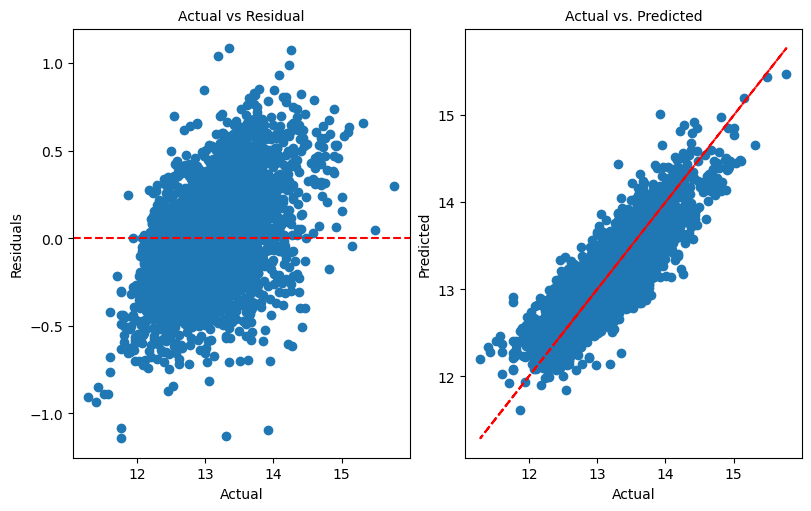

,Model,r2,RMSE,RMSE_orginal_scale,MSPE_orginal_scale,baseline_orginal_scale_RMSE
1,Gradient Boosting Regressor,0.890416,0.173813,137352.779287,0.127204,381572.388539
0,Random Forest Regressor,0.886257,0.177080,146259.187589,0.128452,381572.388539
2,Lasso Regression,0.735711,0.269927,202405.636033,0.213956,381572.388539


In [77]:
summary = evaluate_model(grid_lasso, X_test_selected, y_test, y_train, title = "Lasso Regression")
summaries.append(summary)
pd.DataFrame(summaries).sort_values(by="r2", ascending=False)

In [78]:
# Ridge Regression
from sklearn.linear_model import Ridge
param_grid_ridge = [
    {
        "classifier": [Ridge(random_state = RandomStateNumber)],
        "classifier__alpha": [0.0001, 0.001, 0.01, 1, 10],
        "classifier__solver":["auto", "svd", "cholesky", "lsqr", "sparse_cg"]
    }]
grid_ridge = GridSearchCV(pipe,
                          param_grid = param_grid_ridge,
                          scoring= scoring_metric,
                          n_jobs = -1,
                          cv = kf,
                          verbose=1)
grid_ridge.fit(X_train_selected, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('classifier', Lasso(random_state=13))]),
             n_jobs=-1,
             param_grid=[{'classifier': [Ridge(random_state=13)],
                          'classifier__alpha': [0.0001, 0.001, 0.01, 1, 10],
                          'classifier__solver': ['auto', 'svd', 'cholesky',
                                                 'lsqr', 'sparse_cg']}],
             scoring='r2', verbose=1)

Ridge Regression

Best Model: Pipeline(steps=[('classifier',
                 Ridge(alpha=0.01, random_state=13, solver='sparse_cg'))])
Best Parameters: {'classifier': Ridge(random_state=13), 'classifier__alpha': 0.01, 'classifier__solver': 'sparse_cg'}
Best Score : 0.7308750913172988


Evaluation on test data
R2 score:  0.735848990520976
RMSE:  0.2698565833984333
RMSE on orginal scale:  202,171
MSPE on orginal scale:  21.39%
Baseline RMSE on orginal scale:  381,572


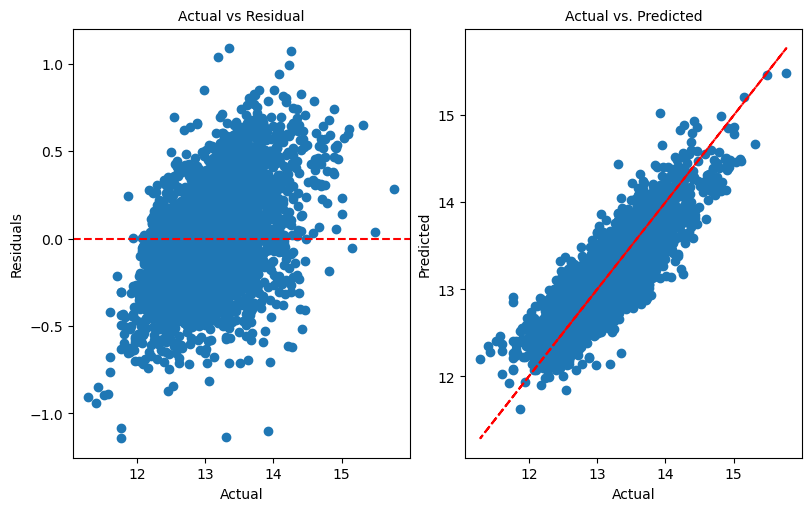

,Model,r2,RMSE,RMSE_orginal_scale,MSPE_orginal_scale,baseline_orginal_scale_RMSE
1,Gradient Boosting Regressor,0.890416,0.173813,137352.779287,0.127204,381572.388539
0,Random Forest Regressor,0.886257,0.177080,146259.187589,0.128452,381572.388539
3,Ridge Regression,0.735849,0.269857,202171.288352,0.213926,381572.388539
2,Lasso Regression,0.735711,0.269927,202405.636033,0.213956,381572.388539


In [79]:
summary = evaluate_model(grid_ridge, X_test_selected, y_test, y_train, title = "Ridge Regression")
summaries.append(summary)
pd.DataFrame(summaries).sort_values(by="r2", ascending=False)

In [80]:
# KNeighbors Regressor 
param_grid_knr = [
  {
    'classifier': [KNeighborsRegressor()],
    'classifier__n_neighbors': [5, 10, 15, 20, 50],
    'classifier__leaf_size': [10, 20, 30, 40, 50],
    'classifier__metric': ["minkowski", "euclidean", "manhattan"],
    'classifier__weights': ['uniform', 'distance'],
  }]

grid_knr = GridSearchCV(pipe,
                          param_grid = param_grid_knr,
                          scoring= scoring_metric,
                          n_jobs = -1,
                          cv = kf,
                          verbose=1)
start_time = time.time()
grid_knr.fit(X_train_selected, y_train)
print("Time taken sec", time.time() - start_time)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Time taken sec 5.3470258712768555


KNeighbors Regressor

Best Model: Pipeline(steps=[('classifier',
                 KNeighborsRegressor(leaf_size=20, metric='manhattan',
                                     n_neighbors=10))])
Best Parameters: {'classifier': KNeighborsRegressor(), 'classifier__leaf_size': 20, 'classifier__metric': 'manhattan', 'classifier__n_neighbors': 10, 'classifier__weights': 'uniform'}
Best Score : 0.8610120825113358


Evaluation on test data
R2 score:  0.8696516092793358
RMSE:  0.18956568173019084
RMSE on orginal scale:  166,556
MSPE on orginal scale:  13.62%
Baseline RMSE on orginal scale:  381,572


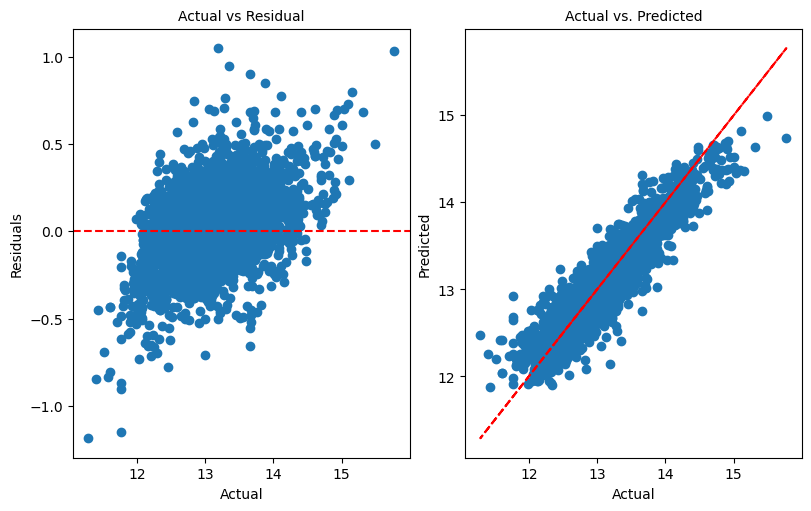

,Model,r2,RMSE,RMSE_orginal_scale,MSPE_orginal_scale,baseline_orginal_scale_RMSE
1,Gradient Boosting Regressor,0.890416,0.173813,137352.779287,0.127204,381572.388539
0,Random Forest Regressor,0.886257,0.177080,146259.187589,0.128452,381572.388539
4,KNeighbors Regressor,0.869652,0.189566,166555.777343,0.136225,381572.388539
3,Ridge Regression,0.735849,0.269857,202171.288352,0.213926,381572.388539
2,Lasso Regression,0.735711,0.269927,202405.636033,0.213956,381572.388539


In [81]:
summary = evaluate_model(grid_knr, X_test_selected, y_test, y_train, title = "KNeighbors Regressor")
summaries.append(summary)
pd.DataFrame(summaries).sort_values(by="r2", ascending=False)

In [82]:
from sklearn.svm import SVR
svr = SVR(kernel='rbf')
param_grid_svr = [
    {
        "classifier": [svr],
        "classifier__C": [0.1, 1, 10, 100],
        "classifier__epsilon": [0.01, 0.1, 0.2],
        "classifier__kernel": ["linear", "poly", "rbf", "sigmoid"]
    }]
grid_svr = GridSearchCV(pipe,
                          param_grid = param_grid_svr,
                          scoring= scoring_metric,
                          n_jobs = -1,
                          cv = kf,
                          verbose=1)
start_time = time.time()
grid_svr.fit(X_train_selected, y_train)
print("Time taken sec", time.time() - start_time)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


/Users/sohengkhiong/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Time taken sec 7049.170244216919


Support Vector Regressor

Best Model: Pipeline(steps=[('classifier', SVR(C=10))])
Best Parameters: {'classifier': SVR(), 'classifier__C': 10, 'classifier__epsilon': 0.1, 'classifier__kernel': 'rbf'}
Best Score : 0.8800536622377347


Evaluation on test data
R2 score:  0.8857727909171692
RMSE:  0.1774563984447473
RMSE on orginal scale:  139,262
MSPE on orginal scale:  13.07%
Baseline RMSE on orginal scale:  381,572


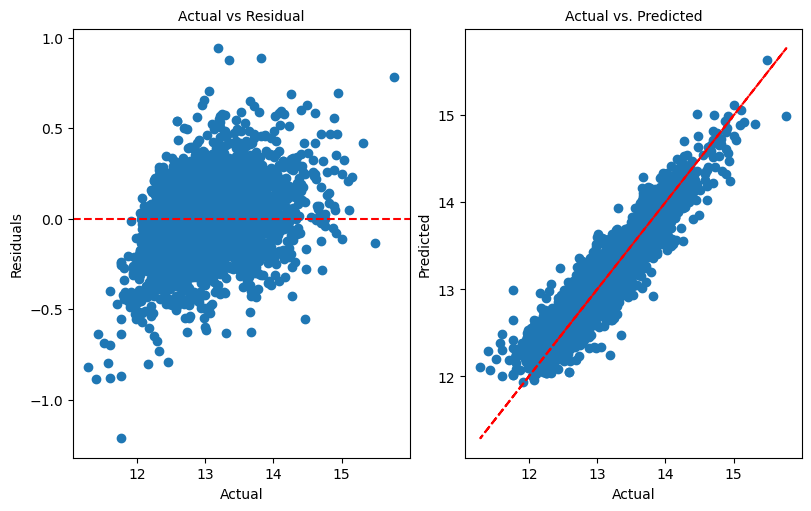

,Model,r2,RMSE,RMSE_orginal_scale,MSPE_orginal_scale,baseline_orginal_scale_RMSE
1,Gradient Boosting Regressor,0.890416,0.173813,137352.779287,0.127204,381572.388539
0,Random Forest Regressor,0.886257,0.177080,146259.187589,0.128452,381572.388539
5,Support Vector Regressor,0.885773,0.177456,139261.938080,0.130685,381572.388539
4,KNeighbors Regressor,0.869652,0.189566,166555.777343,0.136225,381572.388539
3,Ridge Regression,0.735849,0.269857,202171.288352,0.213926,381572.388539
2,Lasso Regression,0.735711,0.269927,202405.636033,0.213956,381572.388539


In [83]:
summary = evaluate_model(grid_svr, X_test_selected, y_test, y_train, title = "Support Vector Regressor")
summaries.append(summary)
pd.DataFrame(summaries).sort_values(by="r2", ascending=False)

### Summary

In [84]:
pd.DataFrame(summaries).sort_values(by = "r2", ascending = False).drop_duplicates(keep="first")

,Model,r2,RMSE,RMSE_orginal_scale,MSPE_orginal_scale,baseline_orginal_scale_RMSE
1,Gradient Boosting Regressor,0.890416,0.173813,137352.779287,0.127204,381572.388539
0,Random Forest Regressor,0.886257,0.177080,146259.187589,0.128452,381572.388539
5,Support Vector Regressor,0.885773,0.177456,139261.938080,0.130685,381572.388539
4,KNeighbors Regressor,0.869652,0.189566,166555.777343,0.136225,381572.388539
3,Ridge Regression,0.735849,0.269857,202171.288352,0.213926,381572.388539
2,Lasso Regression,0.735711,0.269927,202405.636033,0.213956,381572.388539


# Save best model

In [85]:
grid_gb_best = RandomizedSearchCV(bestSelectPipe,
                          param_distributions = param_grid_gb,
                          scoring= scoring_metric,
                          n_iter=50,
                          n_jobs = -1,
                          cv = kf,
                          random_state= RandomStateNumber,
                          verbose=1)

start_time = time.time()
grid_gb_best.fit(X_train, y_train)
print(f"Training time in seconds {time.time()- start_time :.0f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Training time in seconds 246


Gradient Boosting Regressor Best select pipeline

Best Model: Pipeline(steps=[('feature_engineer',
                 FunctionTransformer(func=<function feature_engineer at 0x1689f4220>)),
                ('dropColumn',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop', 'drop',
                                                  ['id', 'date', 'yr_built',
                                                   'yr_renovated', 'year',
                                                   'zipcode'])],
                                   verbose_feature_names_out=False)),
                ('columnTransform',
                 ColumnTransformer(remainder='passthrough',
                                   transfor...
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('removed', 'drop',
                                                  ['sqft_lot', 'condition',
                     

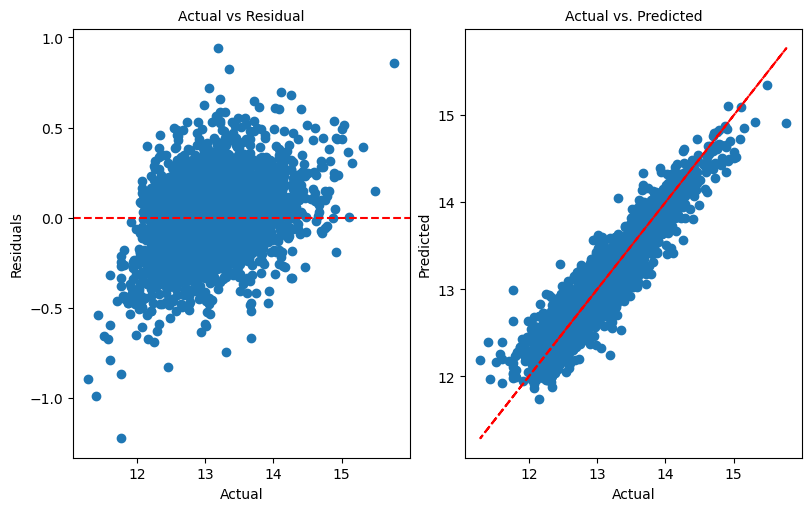

In [86]:
evaluate_model(grid_gb_best, X_test, y_test, y_train, title = "Gradient Boosting Regressor Best select pipeline")

best_model = grid_gb_best.best_estimator_

In [87]:
import joblib

# Define the filename for saving the model
filename = 'kc_best_model_originaldata.pkl'

# Save the best_model using joblib
joblib.dump(best_model, filename)

print(f"Best model saved to {filename}")

Best model saved to kc_best_model_originaldata.pkl


# Model Evaluation

r_score:  0.890415706926371
RSME: 0.17381251166484749
RMSE on orginal scale: 137,353
MSPE on orginal scale:, 12.72%
Baseline RMSE on orginal scale: 381,572


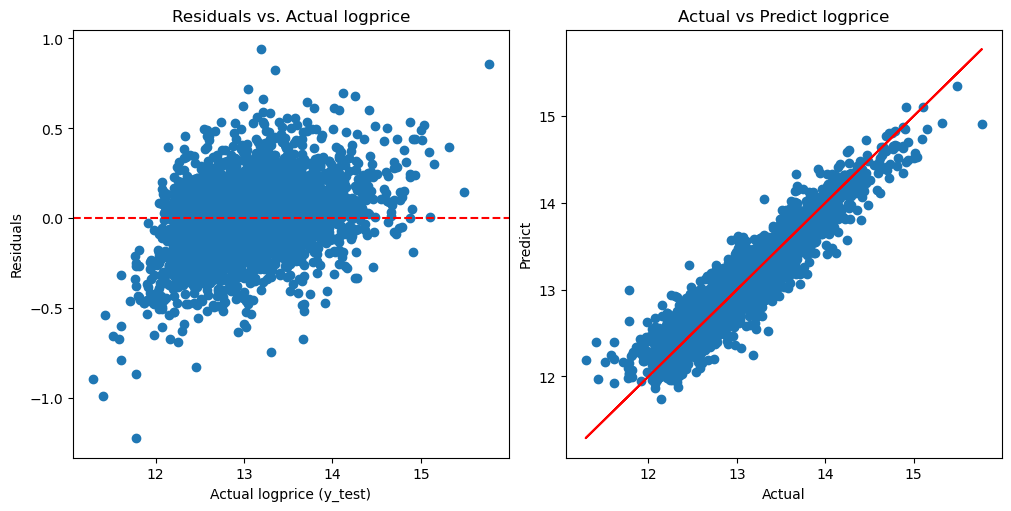

In [88]:
# load the best model
best_model = joblib.load('kc_best_model_originaldata.pkl')

y_pred = best_model.predict(X_test)

residuals = y_test - y_pred

print("r_score: ", r2_score(y_test, y_pred))
print("RSME:", root_mean_squared_error(y_test, y_pred))
print(f"RMSE on orginal scale: {root_mean_squared_error(np.exp(y_test), np.exp(y_pred)):,.0f}")
print(f"MSPE on orginal scale:, {mean_absolute_percentage_error(np.exp(y_test), np.exp(y_pred)):.2%}")
print(f"Baseline RMSE on orginal scale: {root_mean_squared_error(np.exp(y_test), np.full(len(y_test), np.exp(y_train).mean())):,.0f}")


fig = plt.figure(figsize=(10,5), layout = "constrained")
ax1 = fig.add_subplot(121)
plt.scatter(y_test, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual logprice (y_test)')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual logprice')

ax2 = fig.add_subplot(122)
ax2.scatter(y_test, y_pred)
ax2.set_title("Actual vs Predict logprice")
ax2.plot(y_test, y_test, color = "red")
ax2.set_xlabel("Actual")
ax2.set_ylabel("Predict")
plt.show()

In [ ]:
# Orginal scale

residuals_org_scale = np.exp(y_test) - np.exp(y_pred)
y_test_price =  np.exp(y_test)
y_pred_price = np.exp(y_pred)

fig = plt.figure(figsize=(10,5), layout = "constrained")
ax1 = fig.add_subplot(121)
plt.scatter(y_test_price, residuals_org_scale)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Actual price')
plt.ylabel('Residuals')
plt.title('Residuals vs. Actual Price')

ax2 = fig.add_subplot(122)
ax2.scatter(y_test_price, y_pred_price)
ax2.set_title("Actual vs Predict logprice")
ax2.plot(y_test_price, y_test_price, color = "red")
ax2.set_xlabel("Actual")
ax2.set_ylabel("Predict")
plt.show()